In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

In [2]:
cameraCalibration = pickle.load(open('./calibration.p','rb'))
mtx, dist = map(cameraCalibration.get,('mtx','dist'))

In [3]:
def undistort_image(image):
    undistort = cv2.undistort(image,mtx,dist,None,mtx)
    return undistort

def hls(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2HLS)

def grayscale(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

In [4]:
# Image
image = cv2.imread('./test_images/test1.jpg')
# Undistort 
undistort = undistort_image(image)
# HLS
hls_image = hls(undistort)
# Gray
gray = grayscale(undistort)

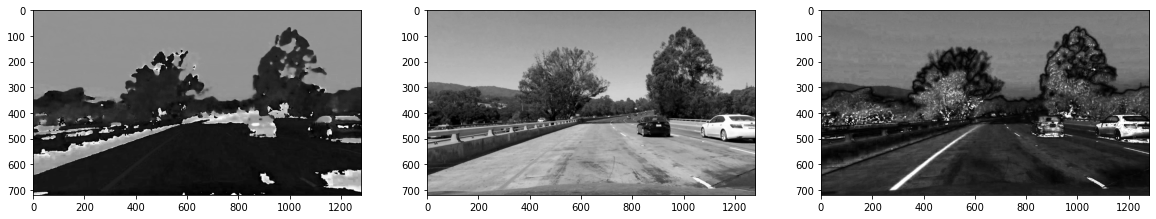

In [5]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,10))
for idx, a in enumerate(axes):
    a.imshow(hls_image[:,:,idx],cmap='gray')

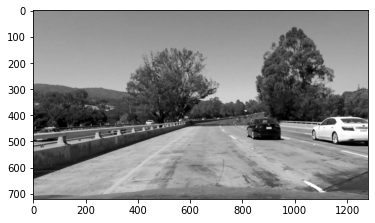

In [6]:
plt.imshow(gray,cmap='gray')

In [7]:
# applying sobel operator based on orientation
def abs_sobel_thresh(img,thresh=(0, 255), orient='x', sobel_kernel=3):
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255.0 * abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1
    return grad_binary

In [8]:
# Magnitude of the gradient
def mag_thresh(image, mag_thresh=(0, 255), sobel_kernel=3):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    scaled_sobel = np.uint8(255.0 * abs_sobel/ np.max(abs_sobel))    
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])] = 1
    return mag_binary

In [9]:
# Direction of the gradient
def dir_threshold(image, thresh=(0, np.pi/2), sobel_kernel=3):
    sobel_x = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    direction = np.arctan2(sobel_y,sobel_x)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction>=thresh[0]) & (direction<=thresh[1])] = 1
    return dir_binary

### Combining Gradient

In [10]:
# Combining gradients
def combined_gradient(image):
    undistort = undistort_image(image)
    image_hls = hls(undistort)
    S = image_hls[:,:,2]
    gradx = abs_sobel_thresh(S,(10,150))
    grady = abs_sobel_thresh(S,(10,150),'y')
    mag = mag_thresh(S,(10,150))
    direction = dir_threshold(S,(0.7,1.2))
    combined = np.zeros_like(gradx)
    combined[((gradx==1) & (grady==1)) | ((mag==1) & (direction==1))] =1
    return combined

In [11]:
test_images = list(map(lambda image_name: (image_name,cv2.imread(image_name)), glob.glob('./test_images/*.jpg')))

In [12]:
def show_images(images,ncols=2,nrows=4,cmap=None):
    n = len(test_images)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,20))
    for axis,idx in zip(axes.flat,range(ncols*nrows)):
        if(idx < n):
            axis.imshow(images[idx][1],cmap=cmap)
        axis.set_title(images[idx][0])
        axis.axis('off')

## Test Images 

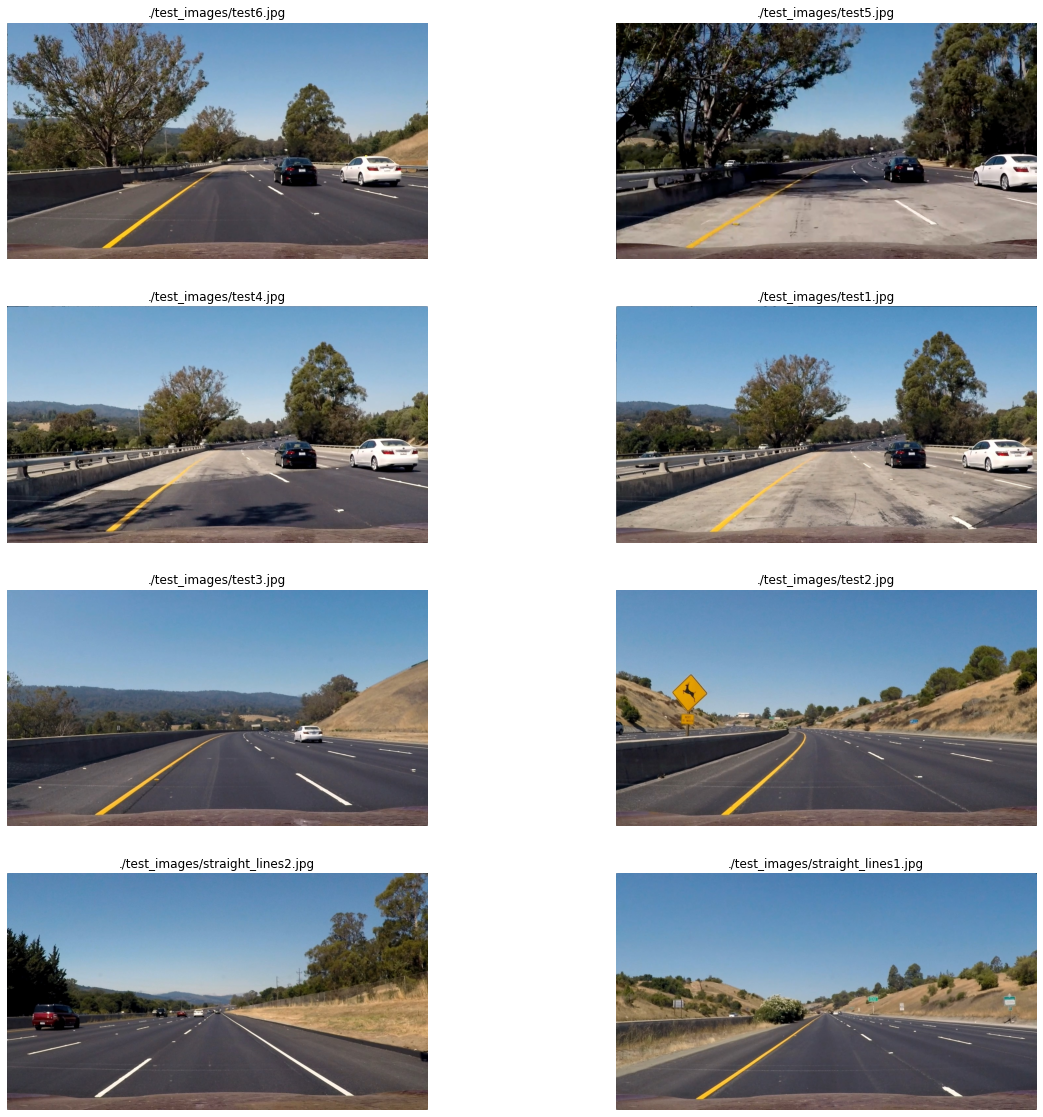

In [13]:
show_images(list(map(lambda img: (img[0],cv2.cvtColor(img[1],cv2.COLOR_BGR2RGB)),test_images)))

In [14]:
hls_images =list(map(lambda img: (img[0],hls(img[1])),test_images)) 

### Applying sobel x operator

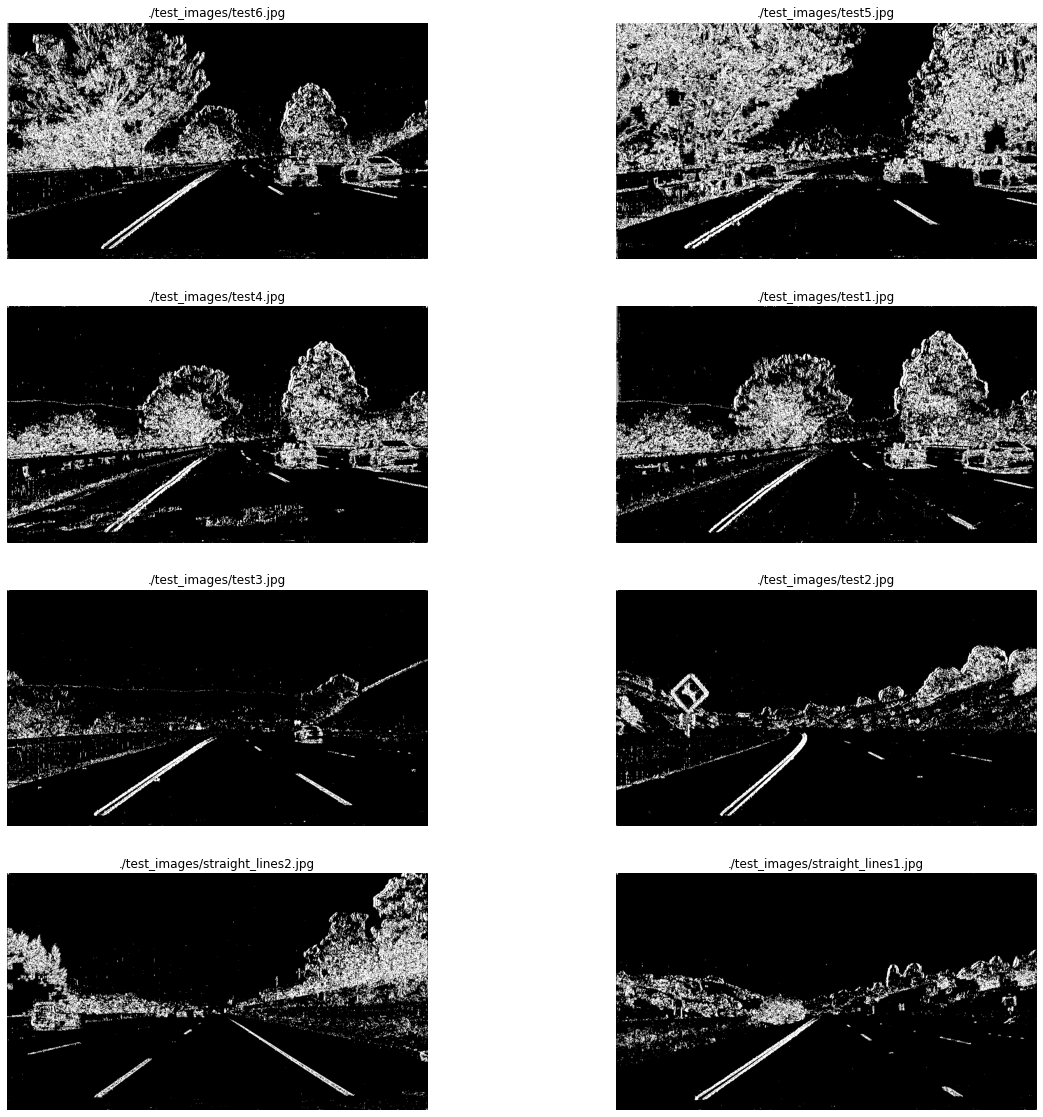

In [15]:
show_images(list(map(lambda img: (img[0],abs_sobel_thresh(img[1][:,:,2],(10,150))),hls_images)),cmap='gray')

### Applying sobel y operator

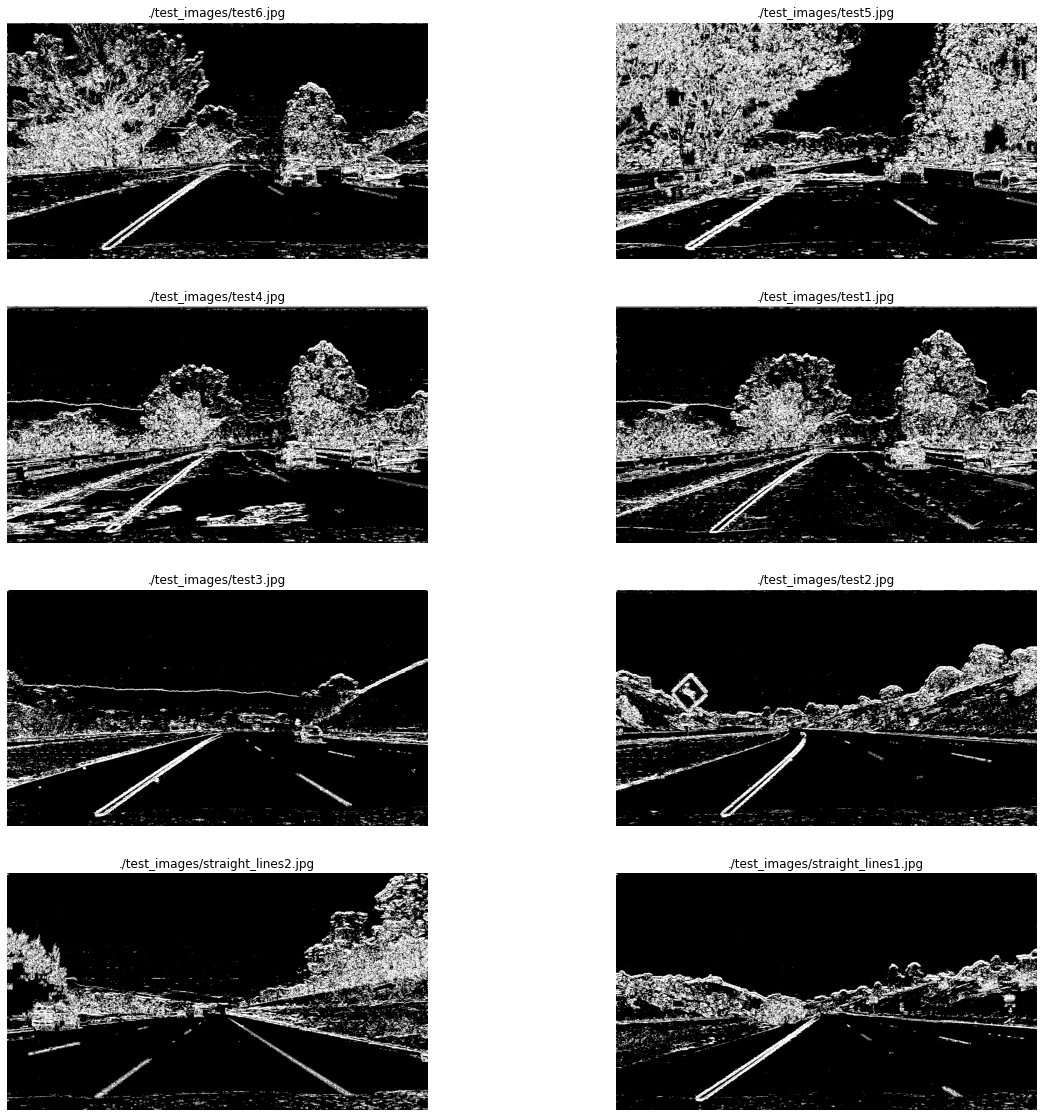

In [16]:
show_images(list(map(lambda img: (img[0],abs_sobel_thresh(img[1][:,:,2],(10,150),'y')),hls_images)),cmap='gray')

## Applying magnitude 

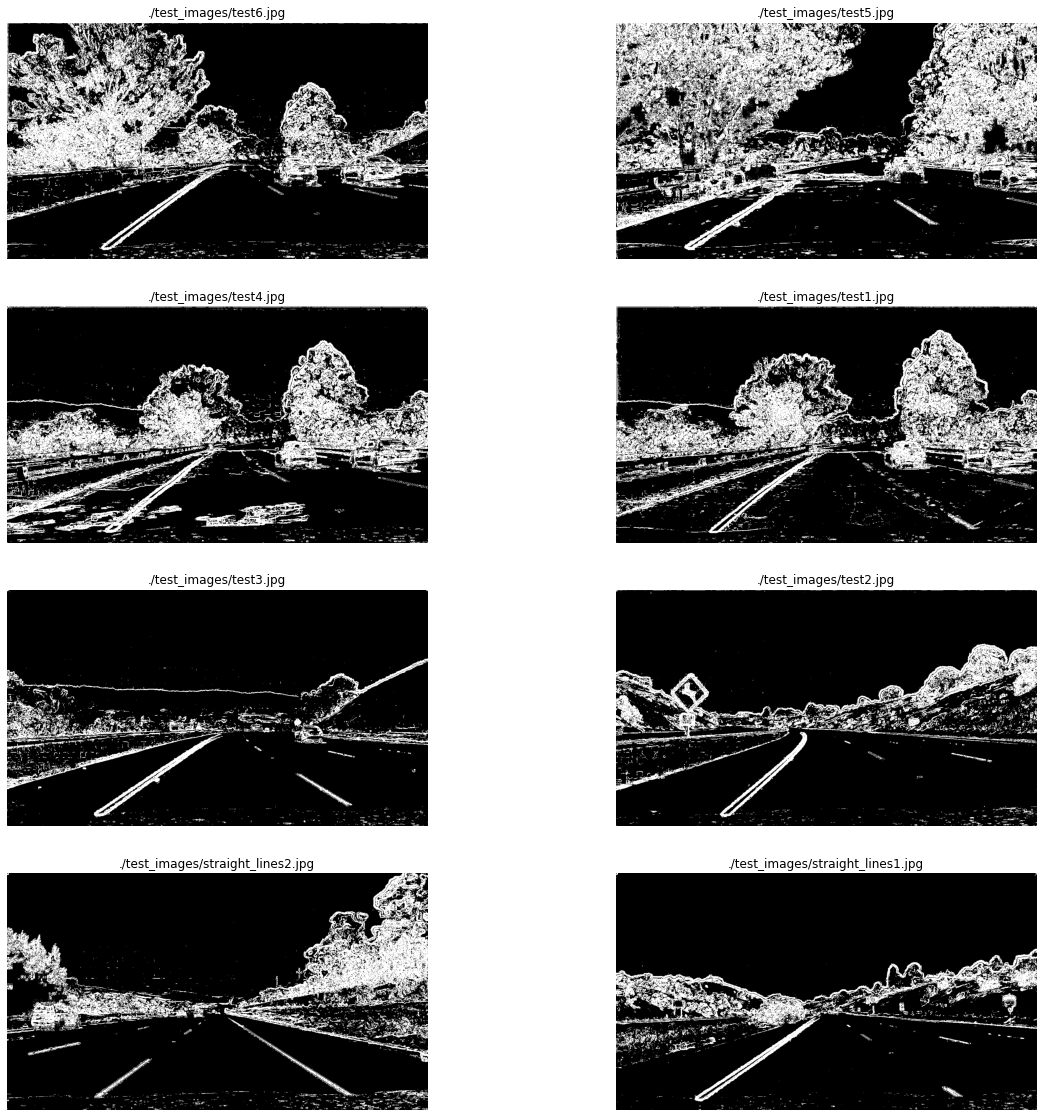

In [17]:
show_images(list(map(lambda img: (img[0],mag_thresh(img[1][:,:,2],(10,150))),hls_images)),cmap='gray')

## Applying direction

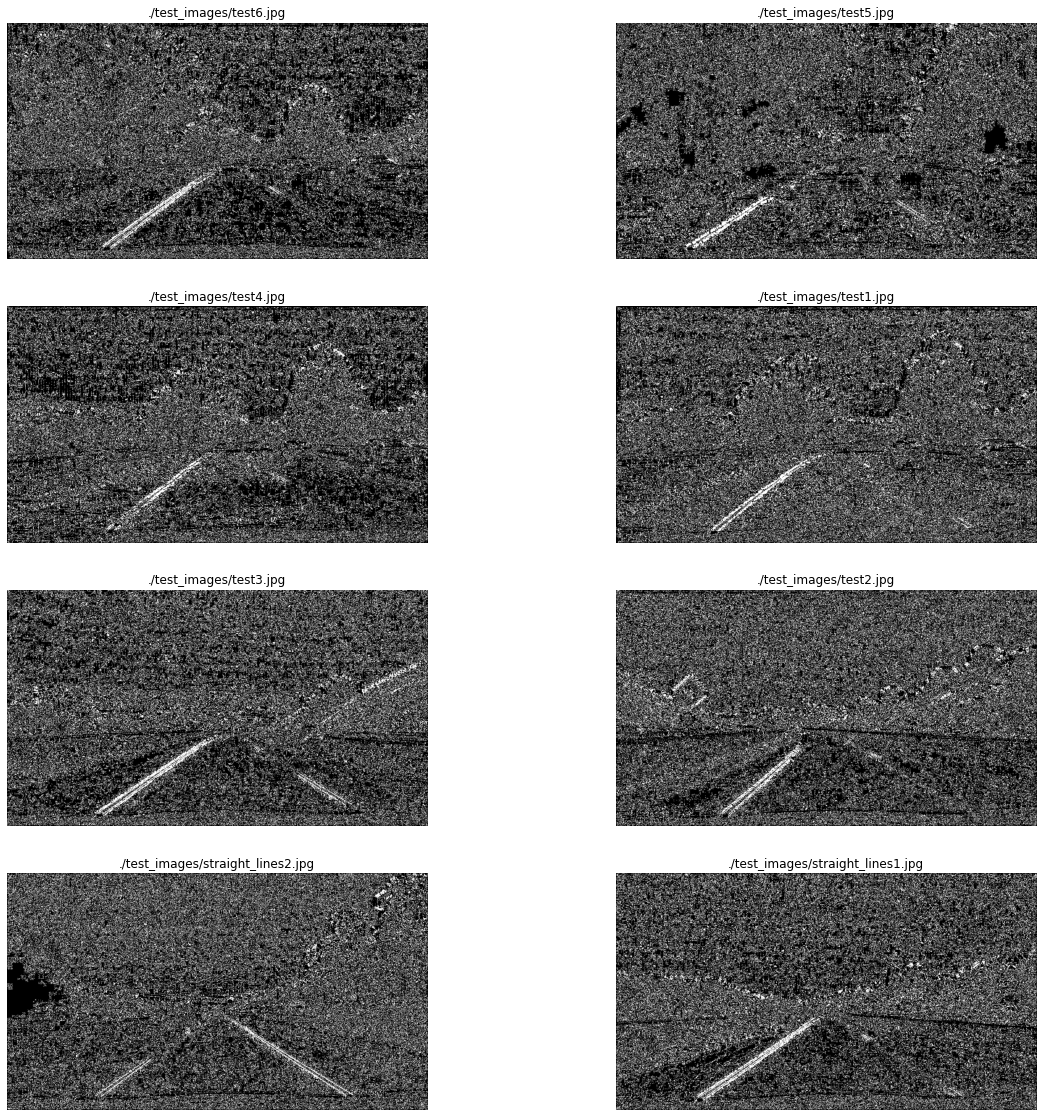

In [18]:
show_images(list(map(lambda img: (img[0],dir_threshold(img[1][:,:,2],(0.7,1.2))),hls_images)),cmap='gray')

## Test Images after applying gradients

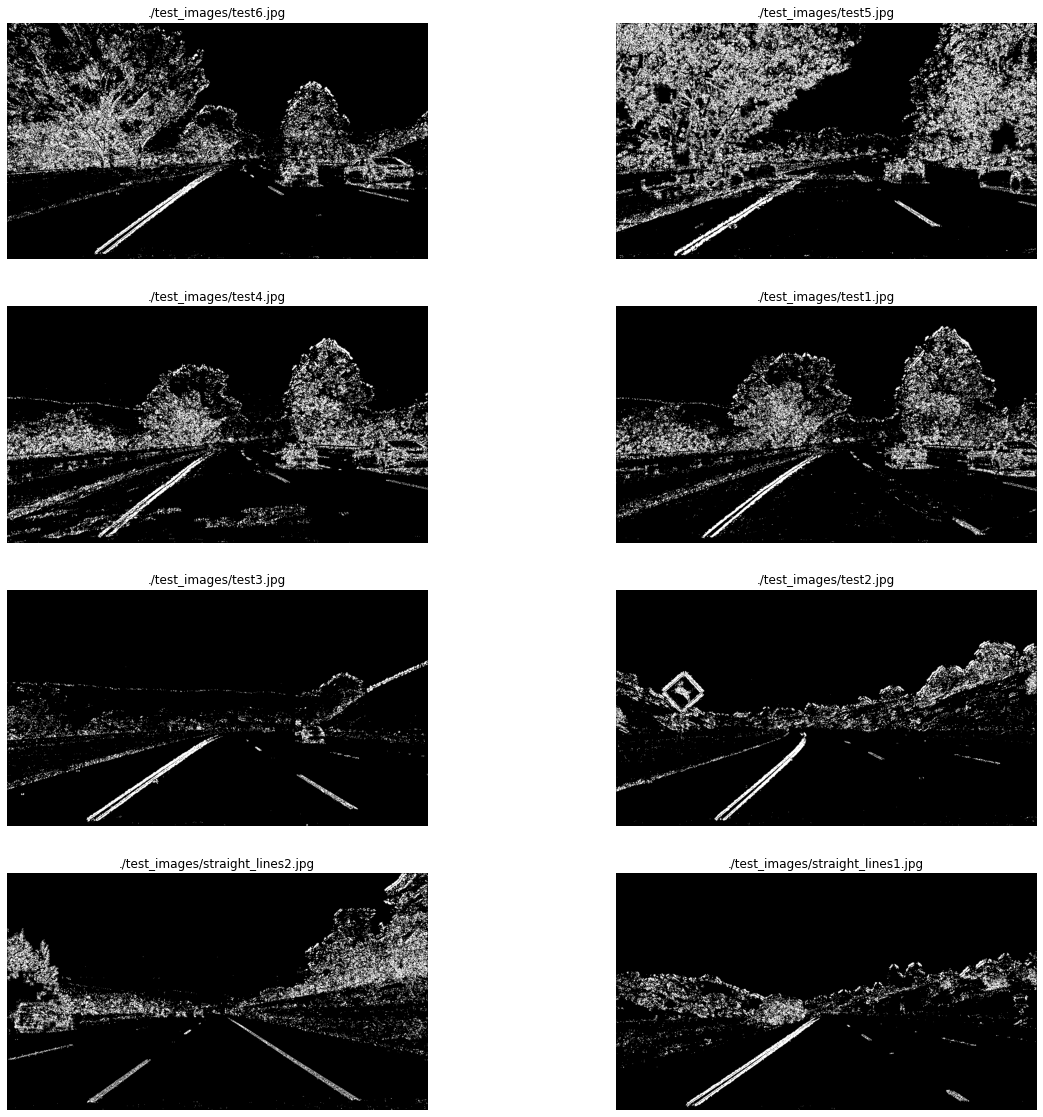

In [19]:
show_images(list(map(lambda img: (img[0],combined_gradient(img[1])),test_images)),cmap='gray')